# Netflix data Analysis

Прошел вводный курс от Яндекса и решил попрактиковаться и сделать мини-проект на реальных данных. В качестве этих самых "реальных данных" буду использовать "Netflix Movies and TV Shows" dataset взятый из топа kaggle.com

Первой гипотезой моего исследования ставлю следующее предположение:
* Is Netflix has increasingly focusing on TV rather than movies in recent years?
    
Считаю, что эту гипотезу вполне можно подтвердить количественными методами анализа, которыми я уже способен оперировать.
Главная задача на данный момент, определить метрику по которой можно будет оценивать именно фокус самого нетфликса на тот или иной сегмент. Ну а пока разберусь с импортом пандаса из Jupiter'a

In [97]:
import pandas as pd

Ну а теперь можно и посмотреть наши данные

## Предобработка данных

In [98]:
df = pd.read_csv('./netflix_titles.csv')

In [99]:
df.tail(30)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7757,s7758,Movie,Zach Galifianakis: Live at the Purple Onion,Michael Blieden,"Zach Galifianakis, Brian Unger",United States,"February 26, 2019",2006,TV-MA,61 min,Stand-Up Comedy,"The unorthodox, piano-playing stand-up star Za..."
7758,s7759,Movie,Zack and Miri Make a Porno,Kevin Smith,"Seth Rogen, Elizabeth Banks, Craig Robinson, J...",United States,"October 1, 2018",2008,R,101 min,"Comedies, Independent Movies, Romantic Movies",Zack and Miri make and star in an adult film t...
7759,s7760,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...
7760,s7761,Movie,Zaki Chan,Wael Ihsan,"Ahmed Helmy, Yasmin Abdulaziz, Hassan Hosny, H...",Egypt,"May 19, 2020",2005,TV-PG,109 min,"Comedies, International Movies, Romantic Movies",An unqualified young man has his work cut out ...
7761,s7762,Movie,Zapped,Peter DeLuise,"Zendaya, Chanelle Peloso, Spencer Boldman, Emi...","Canada, United States","February 1, 2017",2014,TV-Y,92 min,"Children & Family Movies, Comedies",A girl discovers a dog-training app that can g...
7762,s7763,Movie,Zed Plus,Chandra Prakash Dwivedi,"Adil Hussain, Mona Singh, K.K. Raina, Sanjay M...",India,"December 31, 2019",2014,TV-MA,131 min,"Comedies, Dramas, International Movies",A philandering small-town mechanic's political...
7763,s7764,Movie,Zenda,Avadhoot Gupte,"Santosh Juvekar, Siddharth Chandekar, Sachit P...",India,"February 15, 2018",2009,TV-14,120 min,"Dramas, International Movies",A change in the leadership of a political part...
7764,s7765,Movie,Zero,Aanand Rai,"Shah Rukh Khan, Anushka Sharma, Katrina Kaif, ...",India,"May 21, 2019",2018,TV-14,159 min,"Comedies, Dramas, International Movies",Through his relationships with two wildly diff...
7765,s7766,Movie,Zero Hour,Robert O. Peters,"Richard Mofe-Damijo, Alex Ekubo, Ali Nuhu, Rah...",NaN,"December 13, 2019",2018,TV-MA,89 min,"International Movies, Thrillers","After his father passes, the heir to a retail ..."
7766,s7767,TV Show,Zig & Sharko,NaN,NaN,France,"December 1, 2017",2016,TV-Y7,1 Season,"Kids' TV, TV Comedies","Zig, an island-bound hyena, will do anything t..."


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [101]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [102]:
df.duplicated().sum()

0

Переименую столбцы в более интуитивно понятные (мне) имена

In [103]:
cols = list(df.columns)
cols[4] = 'actors'
cols[5] = 'countries'
cols[6] = 'date_added_to_netflix'
cols[10] = 'genres'
df.set_axis(cols, axis='columns', inplace=True)

Дупликатов нет, круто. Но есть много пропущенных значений. Пора определиться, какие данные нам понадобятся для анализа.

     0   show_id       +
     1   type          ++
     2   title         +
     3   director      -
     4   actors          ?
     5   countries       ?
     6   date_added_to_netflix    +
     7   release_year  +
     8   rating        ++
     9   duration      ?
     10  genres        +
     11  description   -
где ++: ключевой параметр
    +: нужный параметр
    ?: может понадобится
    -: не нужен

Чтобы нормально использовать столбец genres, хранящий в себе жанры, с ним стоит поработать отдельно. Есть проблемы:
* названия одних и тех же жанров различаются у сериалов и фильмов, что не позволит сделать выборку одного и того же жанра удобно, но может и можно жить
* разобраться как использовать столбец с множеством значений через запятую

Сделаем это если все таки понадобится, а пока доведем преобработку до конца. Начнем с работой с пустыми значениями

In [104]:
df.isna().sum()

show_id                     0
type                        0
title                       0
director                 2389
actors                    718
countries                 507
date_added_to_netflix      10
release_year                0
rating                      7
duration                    0
genres                      0
description                 0
dtype: int64

Столбцы director, cast, country не выглядят ключевыми поэтому им просто заполняю пробелы значением 'unknown'. А вот записи где значения из date_added_to_netflix пропущены - удалю, так как это один из ключевых параметров анализа.

In [105]:
df.dropna(subset = ['date_added_to_netflix'], inplace = True)
df = df.fillna('unknown')

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   show_id                7777 non-null   object
 1   type                   7777 non-null   object
 2   title                  7777 non-null   object
 3   director               7777 non-null   object
 4   actors                 7777 non-null   object
 5   countries              7777 non-null   object
 6   date_added_to_netflix  7777 non-null   object
 7   release_year           7777 non-null   int64 
 8   rating                 7777 non-null   object
 9   duration               7777 non-null   object
 10  genres                 7777 non-null   object
 11  description            7777 non-null   object
dtypes: int64(1), object(11)
memory usage: 789.9+ KB


Разобьем дату по колонкам, чтобы можно было группировать по году:

In [113]:
from datetime import datetime as dt

df['yr_added'] = pd.to_datetime(df['date_added_to_netflix']).dt.year
df['month_added'] = pd.to_datetime(df['date_added_to_netflix']).dt.month
df['day_added'] = pd.to_datetime(df['date_added_to_netflix']).dt.day
df.drop(columns=['date_added_to_netflix'])

print('Done!')

Done!


## Is Netflix has increasingly focusing on TV show rather than movies in recent years?

Посмотрим количество вышедших на нетфликсе премьер фильмов и сериалов за последнее время с разбивкой по годам:

In [172]:
group = df.groupby(by = ['type', 'yr_added', 'month_added']).count()['title']
d = {'TV Shows': group['TV Show'], 'Movies': group['Movie']}
table = pd.DataFrame(data=d).fillna(0)
table['TV Shows/Movies'] = round(table['TV Shows'] / table['Movies'] * 100, 1)
table.tail(300)
# group.head(10)

TV Shows  Movies  TV Shows/Movies
yr_added month_added                                   
2008     1                 0.0     1.0              0.0
         2                 1.0     0.0              inf
2009     5                 0.0     1.0              0.0
         11                0.0     1.0              0.0
2010     11                0.0     1.0              0.0
...                        ...     ...              ...
2020     9                62.0   116.0             53.4
         10               56.0   117.0             47.9
         11               55.0   103.0             53.4
         12               74.0   101.0             73.3
2021     1                29.0    88.0             33.0

[100 rows x 3 columns]

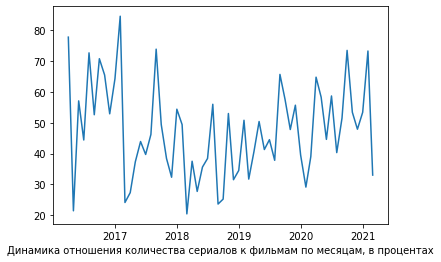

In [182]:
import matplotlib.pyplot as plt
import numpy as np

correlation = table['TV Shows/Movies']

years = 5
indexes = pd.date_range(start=pd.to_datetime('today')-np.timedelta64(years, 'Y'), periods=12*years, freq='M')


plt.plot(indexes, correlation.tail(12*years))
plt.xlabel("Динамика отношения количества сериалов к фильмам по месяцам, в процентах")
plt.show()

### Промежуточные выводы
На графике сложно установить какой либо тенденции. Поэтому, исходя из полученных данных о количестве премьер, нельзя утверждать что сериалов на платформе становится больше, чем фильмов или наоборот.

**Но основываться на этих данных не стоит**, так как реальное положение дел это не описывает. **Одна премьера может собрать огромное количество просмотров, а другая не собрать ничего.**

Более того, можно предположить, что кассовость премьер наоборот толкает скорость выхода новых премьер вниз, так как на их успех расчитывают больше => бюджеты и масштабы увеличиваются => время на сьемку становится больше => меньше премьер в год (высказывание-кандидат на отдельную гипотезу)

Для более качественной проработки нашей основной гипотезы, **нужно достать данные о просмотрах собранных нами картин на нетфликсе.**